In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(4682)

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Kfold cv
from sklearn.model_selection import KFold

# Random forest
from sklearn.ensemble import RandomForestClassifier

# Importing xgboost and shap
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# Feature Selection with Univariate Statistical Tests
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import fbeta_score

import seaborn as sns

# ILPD

# Importing data

In [2]:
import os 
os.listdir('./data/ILPD')

['Indian Liver Patient Dataset (ILPD).csv',
 'ILPD.csv~',
 'UCI Machine Learning Repository_ ILPD (Indian Liver Patient Dataset) Data Set.pdf',
 'ILPD.csv',
 'ILPD.mat']

In [3]:
df = pd.read_csv("data/ILPD/ILPD.csv", sep=' ', header=None)
df.rename(columns={10:"outcome"},inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,outcome
0,65,2,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0        583 non-null    int64  
 1   1        583 non-null    int64  
 2   2        583 non-null    float64
 3   3        583 non-null    float64
 4   4        583 non-null    int64  
 5   5        583 non-null    int64  
 6   6        583 non-null    int64  
 7   7        583 non-null    float64
 8   8        583 non-null    float64
 9   9        579 non-null    float64
 10  outcome  583 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 50.2 KB


In [5]:
df["outcome"] = df["outcome"].map({1:1.0, 2:2.0})
df.head()

,0,1,2,3,4,5,6,7,8,9,outcome
0,65,2,0.7,0.1,187,16,18,6.8,3.3,0.90,1.0
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1.0
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1.0
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1.0
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1.0


In [6]:
df.shape

(583, 11)

In [7]:
df = df.dropna()

In [8]:
df.shape

(579, 11)

# Splitting data

In [9]:
# split data into train and test sets
seed = 7
test_size = 0.33
X = StandardScaler().fit_transform(df.drop('outcome', axis=1))
y = df['outcome'].values
#X_train, X_test, y_train, y_test = train_test_split(X, df.outcome, test_size=test_size, random_state=seed)

### Achieving Better Performance

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
model = rf_random.estimator

model.set_params(**rf_random.best_params_)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy: 67.19%
Accuracy: 67.19%


## Featire Selection

Train Index:  [  0   1   3   4   5   7   8  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  31  32  33  34  35  36  37  38  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  71  74  75  80  85  87  88  89  91  92  93
  94  95  96  97  98  99 100 102 103 105 106 107 108 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 133 134 135
 136 138 139 141 142 143 144 146 147 149 150 151 152 154 156 157 159 160
 161 162 164 166 168 169 170 171 172 173 174 175 178 179 180 181 183 184
 186 187 189 190 191 193 194 195 197 198 200 201 202 203 204 205 206 207
 209 212 213 214 215 216 217 219 221 222 223 224 225 226 228 229 230 231
 232 233 236 237 238 239 240 241 242 243 244 246 248 251 252 253 254 255
 256 257 258 260 262 263 266 267 269 270 271 272 273 275 276 277 278 279
 280 281 282 283 285 287 288 289 290 291 292 293 294 295 297 298 299 300
 301 302 303 304 306 307 308 310 311 

Using 463 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/116 [00:00<?, ?it/s]

Train Index:  [  1   2   3   4   5   6   8   9  10  11  12  13  14  16  17  20  21  23
  24  26  27  28  29  30  32  34  35  36  37  38  39  40  41  43  44  45
  47  48  50  51  52  53  55  58  59  61  62  64  65  66  67  70  71  72
  73  74  76  77  78  79  80  81  82  83  84  85  86  87  90  91  92  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 109 110 111 112 115
 119 120 121 122 123 125 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 142 143 145 146 147 148 150 151 152 153 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 175 176 177 178 179 180 182
 183 185 186 187 188 189 190 191 192 193 194 196 197 198 199 200 201 202
 205 206 207 208 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 229 230 232 233 234 235 236 237 239 240 241 242 243 245
 246 247 249 250 251 252 253 254 256 258 259 260 261 262 263 264 265 266
 267 268 269 270 273 274 275 276 279 280 282 283 284 285 286 288 291 292
 293 294 295 296 297 298 299 300 303 

Using 463 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/116 [00:00<?, ?it/s]

Train Index:  [  0   1   2   4   6   7   8   9  10  11  12  13  14  15  18  19  20  21
  22  25  27  28  29  30  31  32  33  34  35  39  40  41  42  43  44  46
  47  49  51  52  53  54  55  56  57  58  60  61  62  63  64  65  68  69
  70  71  72  73  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  93  95  98  99 100 101 102 104 105 106 107 108 109 110 112
 113 114 115 116 117 118 120 121 122 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 140 141 142 144 145 148 149 151 153 154 155 156
 158 159 160 161 162 163 164 165 166 167 169 170 171 172 173 174 176 177
 178 179 181 182 183 184 185 186 187 188 189 191 192 195 196 197 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 223 224 226 227 228 230 231 232 233 234 235 236 238 240 241
 242 243 244 245 246 247 248 249 250 251 252 254 255 256 257 258 259 260
 261 264 265 267 268 269 270 271 272 273 274 276 277 278 279 281 282 283
 284 285 286 287 288 289 290 292 294 

Using 463 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/116 [00:00<?, ?it/s]

Train Index:  [  0   1   2   3   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  29  30  31  32  33  34  36  37  38  39
  40  42  45  46  47  48  49  50  52  54  55  56  57  58  59  60  61  62
  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  86  87  88  89  90  91  92  93  94  96  97  99 101 102 103
 104 105 106 108 109 110 111 113 114 116 117 118 119 121 123 124 126 128
 130 131 132 134 135 137 138 139 140 141 143 144 145 146 147 148 149 150
 152 153 154 155 156 157 158 160 161 162 163 165 166 167 168 172 173 174
 175 176 177 180 181 182 184 185 187 188 189 190 191 192 193 194 195 196
 198 199 200 201 203 204 205 207 208 209 210 211 212 214 215 216 218 220
 222 225 227 228 229 230 231 234 235 236 237 238 239 241 243 244 245 247
 248 249 250 251 252 253 255 257 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 284 286 287 288 289
 290 291 292 293 295 296 297 298 299 

Using 463 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/116 [00:00<?, ?it/s]

Train Index:  [  0   2   3   4   5   6   7   9  10  11  12  15  16  17  18  19  22  23
  24  25  26  28  29  30  31  33  35  36  37  38  39  41  42  43  44  45
  46  48  49  50  51  53  54  55  56  57  59  60  63  65  66  67  68  69
  70  72  73  74  75  76  77  78  79  81  82  83  84  85  86  88  89  90
  92  93  94  95  96  97  98 100 101 103 104 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 122 123 124 125 126 127 129 131 132 133 136
 137 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 157 158 159 163 164 165 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 188 190 192 193 194 195 196 197 198 199
 202 203 204 206 208 209 210 211 213 217 218 219 220 221 222 223 224 225
 226 227 228 229 231 232 233 234 235 237 238 239 240 242 244 245 246 247
 248 249 250 253 254 255 256 257 258 259 261 262 263 264 265 266 268 271
 272 274 275 277 278 280 281 282 283 284 285 286 287 289 290 291 293 294
 296 297 298 299 301 302 303 304 305 

Using 464 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/115 [00:00<?, ?it/s]

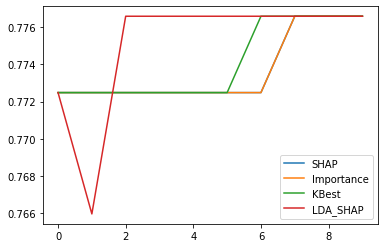

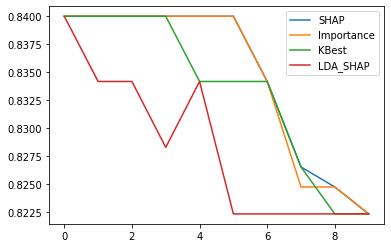

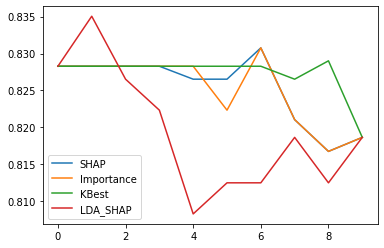

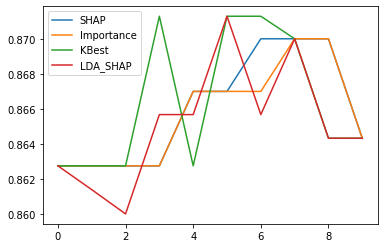

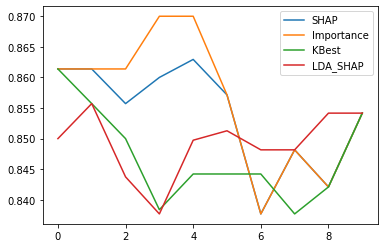

In [11]:
results = []

cv = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    
#     model = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    model = rf_random.estimator
    model.set_params(**rf_random.best_params_)
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    
    # explain the model's predictions using SHAP
    # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    features = df.columns[df.columns!='outcome']
    #df[features]

    # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
    #shap.force_plot(explainer.expected_value[0], shap_values[0][0], df[features].iloc[0,:], feature_names=features)

    #shap.force_plot(explainer.expected_value[0], shap_values[0], df[features])

    #shap.summary_plot(shap_values[0], df[features])

    # shap.summary_plot(shap_values, df[features], plot_type="bar")

    mean_shap_values = np.mean(np.abs(shap_values[0]), axis=0)
    shap_df = pd.DataFrame(mean_shap_values, index=df[features].columns, columns=["SHAP"])
    shap_df.sort_values(by="SHAP", inplace=True, ascending=False)
    # shap_df.plot(kind="bar")
    
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
                 axis=0)

    indices = np.argsort(importances)[::-1]

    fi_df = pd.DataFrame(dict(zip(features[indices], importances[indices])), index=['Importance'])
    fi_df = fi_df.T
    # fi_df.head()
    # fi_df.plot(kind="bar")
    
    test = SelectKBest(score_func=f_classif, k=X_train.shape[1])
    fit = test.fit(X_train, y_train)
    # summarize scores
    set_printoptions(precision=3)
    # print(fit.scores_)

    kbest_dict = dict(zip(df.drop('outcome', axis=1).columns, fit.scores_))
    kbest_df = pd.DataFrame(kbest_dict, index=['KBest']).transpose()
    kbest_df.sort_values(by='KBest', ascending=False, inplace=True)
    # kbest_df.plot(kind="bar")
    
    # Transforming X from numpy to pandas to recover features
    X_train_df = pd.DataFrame(X_train, columns=df.drop(["outcome"], axis=1).columns)
    X_test_df = pd.DataFrame(X_test, columns=df.drop(["outcome"], axis=1).columns)

    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    lda.fit(X_train_df.values, y_train)
    y_pred = lda.predict(X_test_df)
    # use Kernel SHAP to explain test set predictions
    explainer = shap.KernelExplainer(lda.predict_proba, X_train_df, link="logit")
    shap_values = explainer.shap_values(X_test, nsamples=100)
    
    # plot the SHAP values for the Setosa output of the first instance
    # shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_df.iloc[0,:], link="logit")

    lda_shap_df = pd.DataFrame(np.mean(np.abs(shap_values[0]), axis=0), index=X_train_df.columns, columns=["LDA_SHAP"])
    lda_shap_df.sort_values(by="LDA_SHAP", ascending=False, inplace=True)
    # lda_shap_df.head()
    # lda_shap_df.plot(kind="bar")
    
    fs_df = pd.DataFrame(list(zip(shap_df.index, fi_df.index, kbest_df.index, lda_shap_df.index)), columns=["SHAP", "Importance", "KBest", "LDA_SHAP"])
    fs_df.head()
    # Initializing dataframe for results
    LDA_scores = pd.DataFrame(index=range(fs_df.shape[0]), columns=fs_df.columns)
    # Filling in LDA scores
    for num_features in range(fs_df.shape[0]):
        fs_df.iloc[:num_features+1]
        for method in fs_df.columns:
            selected_features = fs_df.iloc[:num_features+1][method]
            lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
            y_pred = lda.fit(X_train_df[selected_features].values, y_train).predict(X_test_df[selected_features])
            LDA_scores.loc[num_features, method] = fbeta_score(y_test, y_pred, beta=1)
    
    results.append(LDA_scores)
    LDA_scores.plot()

Text(0.5, 1.0, 'ILPD Database')

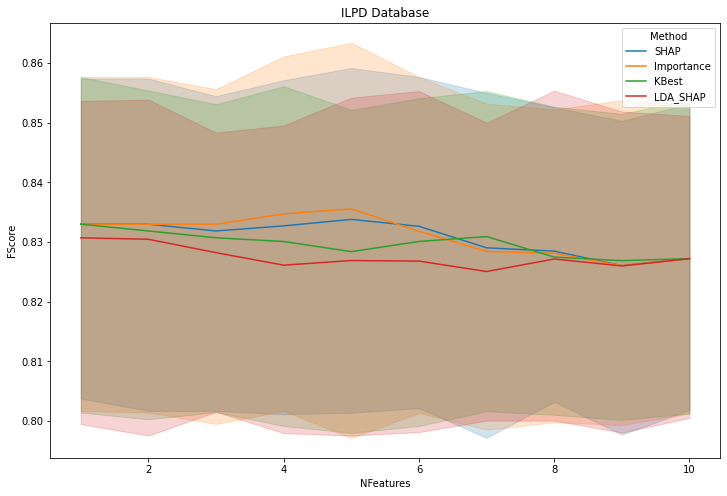

In [12]:
columns = results[0].columns
CV_LDA_scores = pd.DataFrame(columns=["FScore", "NFeatures", "Method", "Fold"])

for fold, lda_result in enumerate(results):
    for col in columns:
        test_df = pd.DataFrame({"FScore" : lda_result[col],
                                "NFeatures": np.arange(len(lda_result))+1,
                                "Method": [col]*len(lda_result),
                                "Fold": [fold]*len(lda_result)})
        CV_LDA_scores = pd.concat([CV_LDA_scores, test_df])
        
# Asserting data types
CV_LDA_scores.FScore = CV_LDA_scores.FScore.astype(float)
CV_LDA_scores.NFeatures = CV_LDA_scores.NFeatures.astype(int)

# Plot
a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data=CV_LDA_scores, x="NFeatures", y="FScore", hue="Method").set_title('ILPD Database')

Text(0.5, 1.0, 'Heart Disease Database')

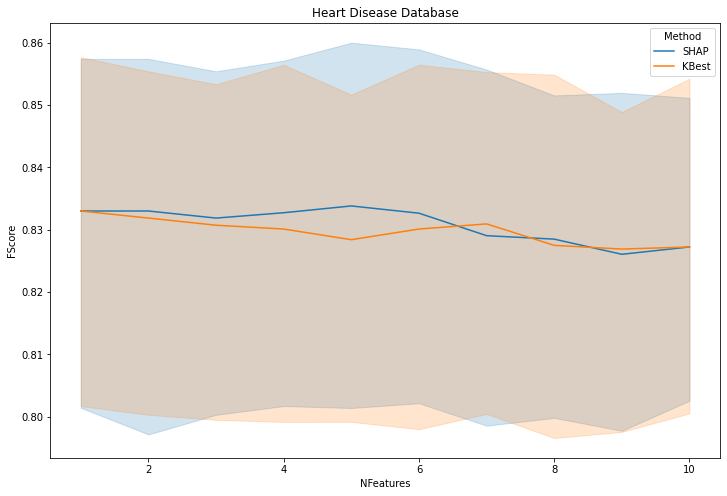

In [13]:
# Plot
a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(data=CV_LDA_scores[CV_LDA_scores['Method'].isin(['KBest', 'SHAP'])], x="NFeatures", y="FScore", hue="Method").set_title('Heart Disease Database')